In [1]:
from functorch.dim.reference import no_slice
from scipy.io import loadmat
import numpy as np
from PIL import Image
from scipy.special import iv  # Bessel Function
import matplotlib.pyplot as plt

In [30]:
import h5py

mat_data = h5py.File("data/assignmentImageDenoising_microscopy.mat", "r")

noisy_data = np.array(mat_data['microscopyImageNoisyScale350sigma0point06'])
noiseless_data = np.array(mat_data['microscopyImageOrig'])
print(noiseless_data)

[[[161 159 163 ... 197 207 220]
  [151 159 168 ... 214 210 226]
  [148 167 159 ... 216 215 224]
  ...
  [157 144 143 ... 230 225 230]
  [170 159 153 ... 228 220 226]
  [188 183 185 ... 221 220 223]]

 [[137 133 133 ... 184 198 209]
  [127 133 139 ... 202 202 216]
  [124 143 133 ... 208 211 217]
  ...
  [ 81  70  72 ... 239 234 239]
  [111  99  93 ... 236 233 238]
  [138 132 130 ... 230 234 237]]

 [[149 146 146 ... 216 224 229]
  [137 146 155 ... 232 225 233]
  [132 155 157 ... 231 230 232]
  ...
  [112  96  89 ... 248 243 243]
  [155 139 124 ... 253 247 248]
  [186 176 169 ... 250 252 249]]]


In [20]:
def l2_norm(x):
    return np.sqrt(np.sum(np.square(x)))

def sqr_l2_norm(x):
    return np.sum(np.square(x))

def huber_norm(x, delta=1.0):
    abs_x = np.abs(x)
    return np.where(abs_x <= delta, 0.5 * x**2, delta * (abs_x - 0.5 * delta))

In [16]:
def save_image(data: np.ndarray, filename):
    """
    Extracts image data from a .mat file, normalizes it, and saves it as a PNG file.

    Parameters:
        data (np.ndarray): input data (expected shape: (channels, height, width))
        filename (str): Name of the file to save the image to.
    """

    data_normalized = (255 * (data - np.min(data)) / (np.max(data) - np.min(data))).astype(np.uint8)

    if data_normalized.shape[0] == 3:
        data_normalized = np.transpose(data_normalized, (1, 2, 0))

    plt.imshow(data_normalized)
    plt.axis("off")
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)


In [33]:
def RRMSE(noisy_data: np.ndarray, noiseless_data: np.ndarray) -> float:
    """
    Computes the Relative Root Mean Squared Error (RRMSE) between the noisy and noiseless data.
    """

    return np.sqrt(np.sum(np.square((noisy_data - noiseless_data)))) / np.sqrt(np.sum(np.square(noiseless_data)))


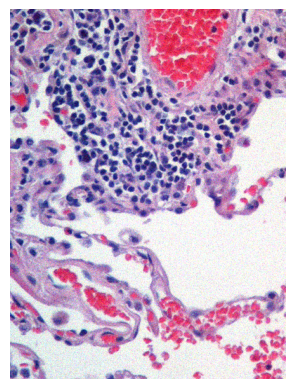

In [17]:
save_image(noiseless_data, 'micro_noiseless.png')
save_image(noisy_data, 'micro_noisy.png')

In [ ]:
def RRMSE(noisy_data: np.ndarray, noiseless_data: np.ndarray) -> float:
    """
    Computes the Relative Root Mean Squared Error (RRMSE) between the noisy and noiseless data.
    """

    return np.sqrt(np.sum(np.square((noisy_data - noiseless_data)))) / np.sqrt(np.sum(np.square(noiseless_data)))


Gaussian Noise Model


In [35]:
def grad_gaussian_log_likelihood(data:np.ndarray, model:np.ndarray) -> np.ndarray:
    """
    Returns:
        np.ndarray: The gradient of the log likelihood.
    """
    return model - data

A) MRF Model with squared L2 norm

In [84]:
def grad_log_sqr_l2(data: np.ndarray, delta: float = 1.0) -> np.ndarray:
    """
    Returns:
        np.ndarray: The gradient of squared l2 norm prior.
    """
    diff = np.zeros_like(data)

    for axis in range(data.ndim-1):
        diff += np.clip(np.abs(data - np.roll(data, shift=-1, axis=axis)), -1e6, 1e6)
    norm = np.linalg.norm(diff, 2)
    return diff / norm if norm != 0 else np.zeros_like(diff)


In [ ]:
obj_quad = []
def gradient_descent_quad(data, lr=0.01, decay=0.05, max_iter=500, alpha=0.9, tol=1e-6):
    model = data.copy()
    step_size = lr
    for t in range(max_iter):
        gauss = grad_gaussian_log_likelihood(data, model)
        grad = (1-alpha) *gauss+ alpha *grad_log_sqr_l2(model)
        obj_quad.append(np.sum(np.square(gauss)))
        step_size /= (1 + decay)
        if step_size < tol:
            break
        model -= step_size * grad
    return model

In [94]:
ans_quad = gradient_descent_quad(noisy_data)
print("Denoised Image", RRMSE(ans_quad, noiseless_data))
print("Original Image", RRMSE(noisy_data, noiseless_data))

Denoised Image 3.8721602729646536
Original Image 3.694910122377646


B) MRF Model with L2 Norm

In [ ]:
def squared_l2_norm_gradient(x):
    """
    Returns:
        np.ndarray: The gradient of squared l2 norm prior.
    """
    return 2 * x

def l2_norm_gradient(x):
    """
    Returns:
        np.ndarray: The gradient of squared l2 norm prior.
    """


def log_squared_l2_norm_gradient(x):
    """
    Returns:
        np.ndarray: The gradient of squared l2 norm prior.
    """
    norm_squared = np.dot(x, x)
    return (2 * x) / norm_squared if norm_squared != 0 else np.zeros_like(x)

def log_l2_norm_gradient(x):
    """
    Returns:
        np.ndarray: The gradient of squared l2 norm prior.
    """
    norm_squared = np.dot(x, x)
    return x / norm_squared if norm_squared != 0 else np.zeros_like(x)

In [95]:
def grad_log_l2(data: np.ndarray, delta: float = 1.0) -> np.ndarray:
    """
    Returns:
        np.ndarray: The gradient of squared l2 norm prior.
    """
    diff = np.zeros_like(data)

    for axis in range(data.ndim-1):
        diff += np.clip(np.abs(data - np.roll(data, shift=-1, axis=axis)), -1e6, 1e6)
    return diff


In [ ]:
obj_l2 = []
def gradient_descent_l2(data, lr=0.01, decay=0.05, max_iter=500, alpha=0.9, tol=1e-6):
    model = data.copy()
    step_size = lr
    for t in range(max_iter):
        gauss = grad_gaussian_log_likelihood(data, model)
        grad = (1-alpha) *gauss+ alpha *grad_log_l2(model)
        # obj_l2.append(np.sum(np.square(gauss)))
        step_size /= (1 + decay)
        if step_size < tol:
            break
        model -= step_size * grad
    return model